In [119]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [120]:
isotherm_type = "linear"

In [121]:
base_dir = Path("../data_out_github_c/default_finn")
u_ret = np.load(base_dir / "u_ret.npy")
ret_freundlich = np.load(base_dir / f"retardation_{isotherm_type}.npy")

In [122]:
Nt = 251
c = np.load(Path(f"../data/synthetic_data/retardation_{isotherm_type}/c_train.npy"))[:Nt, 0, :]
assert c.shape[0] == Nt
c.shape

(251, 26)

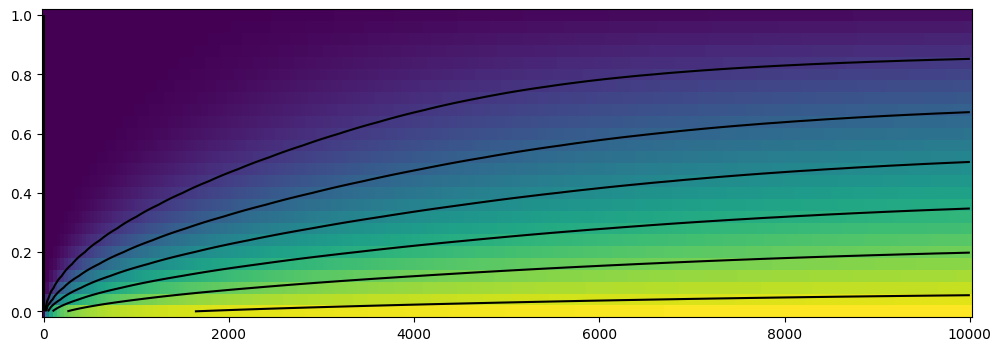

In [123]:
Nx = c.shape[1]
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 10000, Nt)

plt.figure(figsize=(12, 4))
plt.pcolormesh(t, x, c.T)
plt.contour(t, x, c.T, colors="black")
# plt.contour(t, x, c.T, linewidths=4)
plt.show()

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

In [125]:
def f(x,t):
    return np.sin(np.pi * x) * np.exp(-t / 5000)
def dfdt(x,t):
    return -1 / 5000 * np.sin(np.pi * x) * np.exp(-t / 5000)
def dfdx(x,t):
    return np.pi * np.cos(np.pi * x) * np.exp(-t / 5000)
def d2fdx2(x,t):
    return - np.pi**2 * np.sin(np.pi * x) * np.exp(-t / 5000)

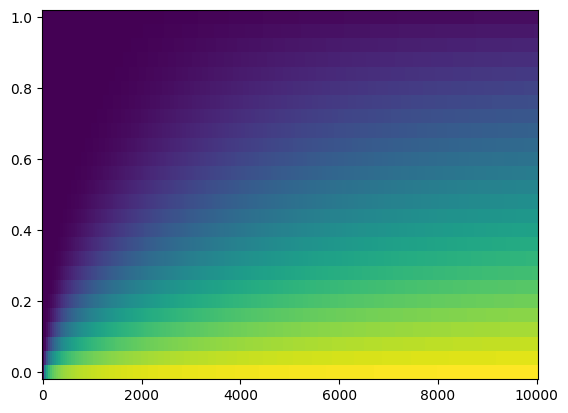

In [126]:
# Example data: Assuming `c(x,t)` is given or generated somehow
# Here we'll use a simple synthetic function for illustration
X, T = np.meshgrid(x,t)
# c = f(X,T)

plt.pcolormesh(t, x, c.T)
plt.show()

In [127]:
c.shape, x.shape, t.shape

((251, 26), (26,), (251,))

In [128]:
# Create a B-spline surrogate model for c(x,t)
spline = RectBivariateSpline(x, t, c.T)
spline(x,t).shape

(26, 251)

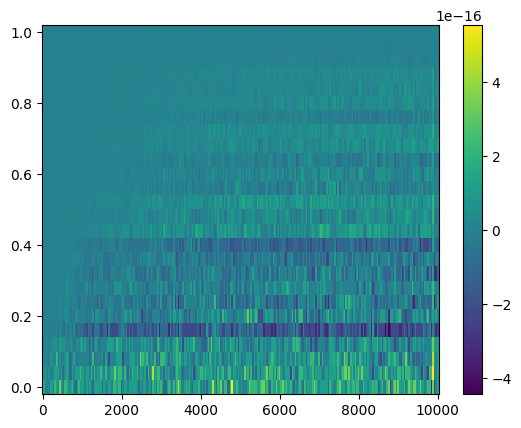

In [129]:
plt.colorbar(plt.pcolormesh(t,x,spline(x,t) - c.T))
plt.show()

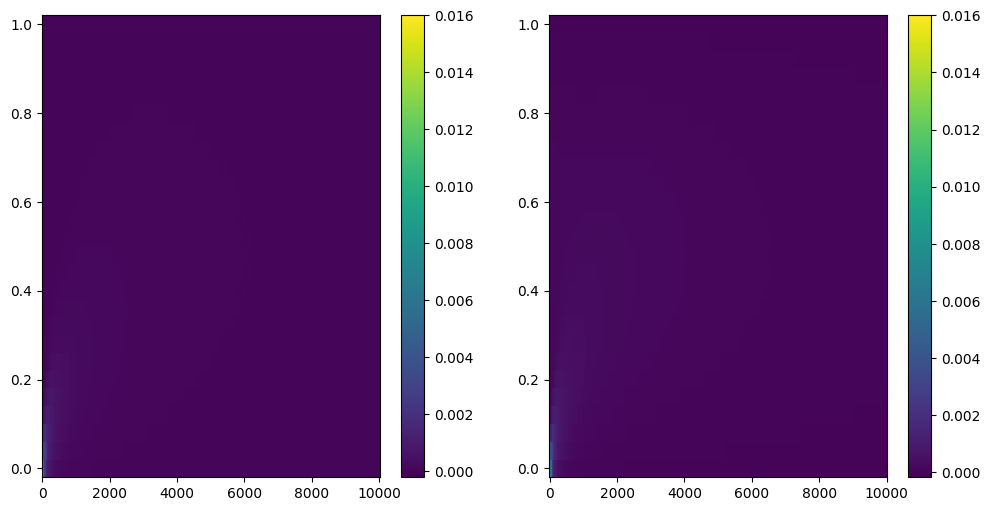

In [130]:
# Compute derivatives
# First derivative with respect to t (time)
dc_dt = spline(x, t, dy=1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plt.colorbar(ax1.pcolormesh(t,x,dc_dt))
plt.colorbar(ax2.pcolormesh(t,x,dc_dt - dfdt(X,T).T))
plt.show()

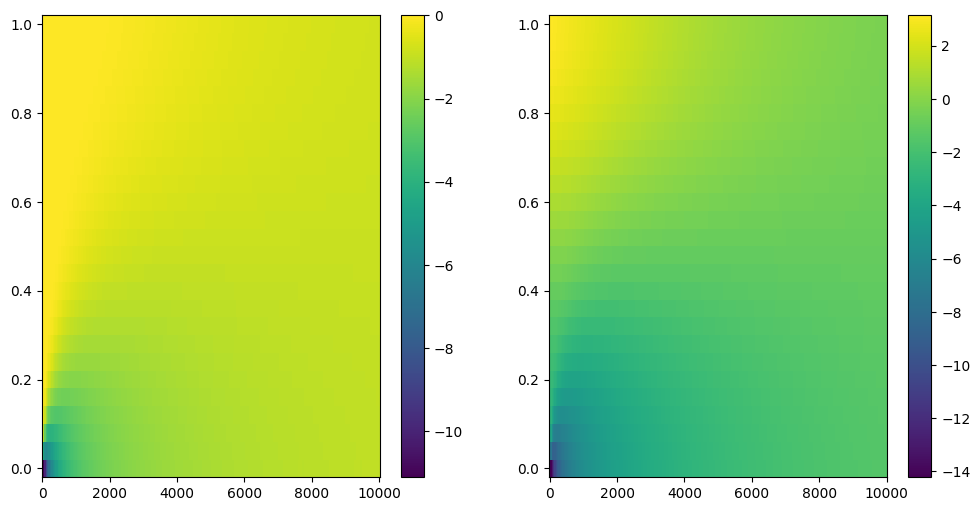

In [131]:
# First derivative with respect to x (space)
dc_dx = spline(x, t, dx=1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plt.colorbar(ax1.pcolormesh(t,x,dc_dx))
plt.colorbar(ax2.pcolormesh(t,x,dc_dx - dfdx(X,T).T))
plt.show()

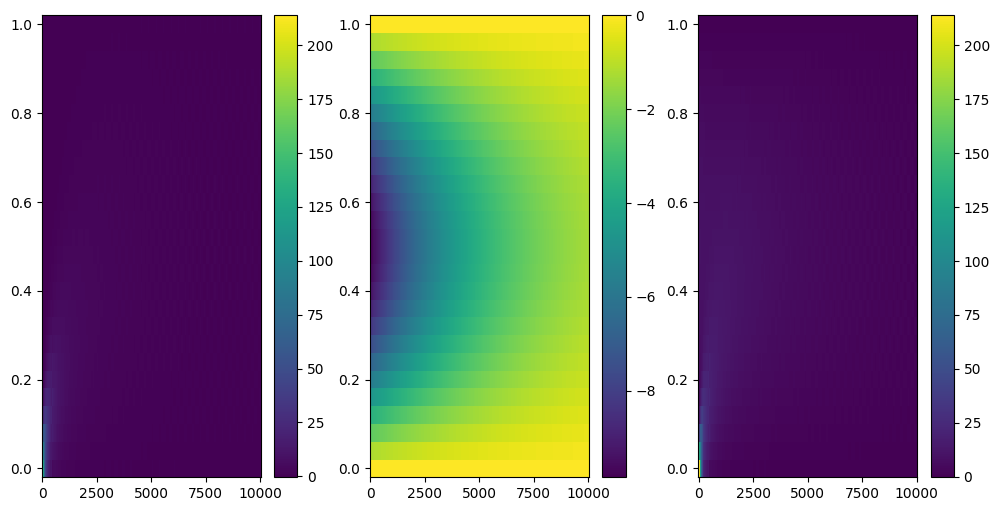

In [132]:
# Second derivative with respect to x (space)
d2c_dx2 = spline(x, t, dx=2)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 6))
plt.colorbar(ax1.pcolormesh(t,x,d2c_dx2))
plt.colorbar(ax2.pcolormesh(t,x,d2fdx2(X,T).T))
plt.colorbar(ax3.pcolormesh(t,x,d2c_dx2 - d2fdx2(X,T).T))
plt.show()

(26, 251) -514510.97605792905 332169.50909660757


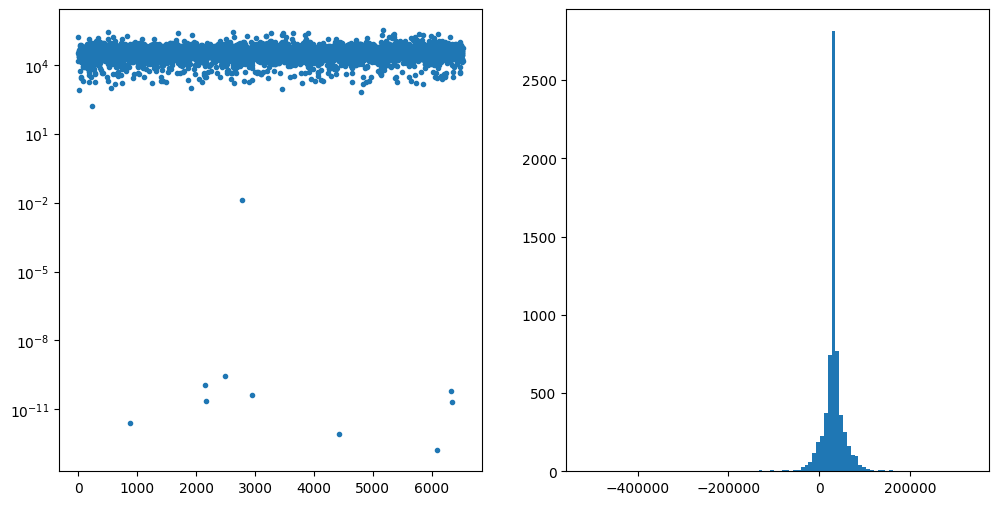

In [144]:
# Compute R(c(x,t)) = d²c/dx² / dc/dt
R_field = d2c_dx2 / dc_dt

print(R_field.shape, R_field.min(), R_field.max())

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
N = len(R_field.ravel())
ax1.semilogy(np.random.choice(np.arange(0, N), N, replace=False), R_field.ravel(), ".")
ax2.hist(R_field.ravel(), bins=100)
plt.show()

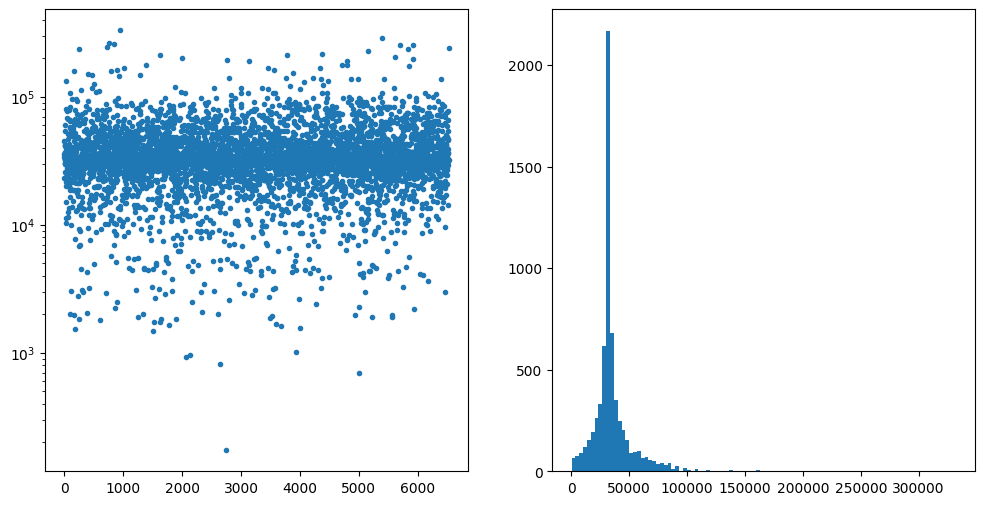

In [147]:
R_field_fixed_outliers = R_field.copy()
R_field_fixed_outliers[R_field < 10] = np.median(R_field)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
N = len(R_field_fixed_outliers.ravel())
ax1.semilogy(np.random.choice(np.arange(0, N), N, replace=False), R_field_fixed_outliers.ravel(), ".")
ax2.hist(R_field_fixed_outliers.ravel(), bins=100)
plt.show()

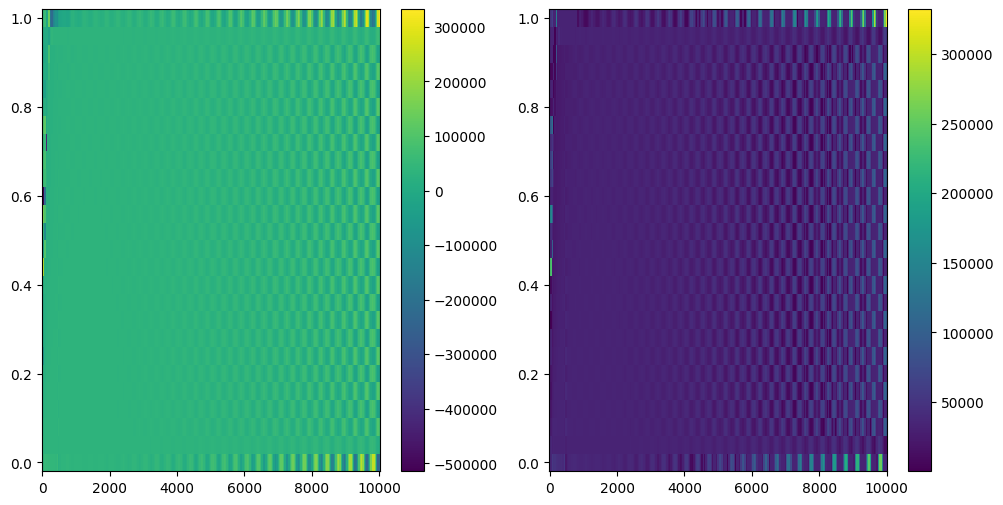

In [148]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plt.colorbar(ax1.pcolormesh(t,x,R_field))
plt.colorbar(ax2.pcolormesh(t,x,R_field_fixed_outliers))

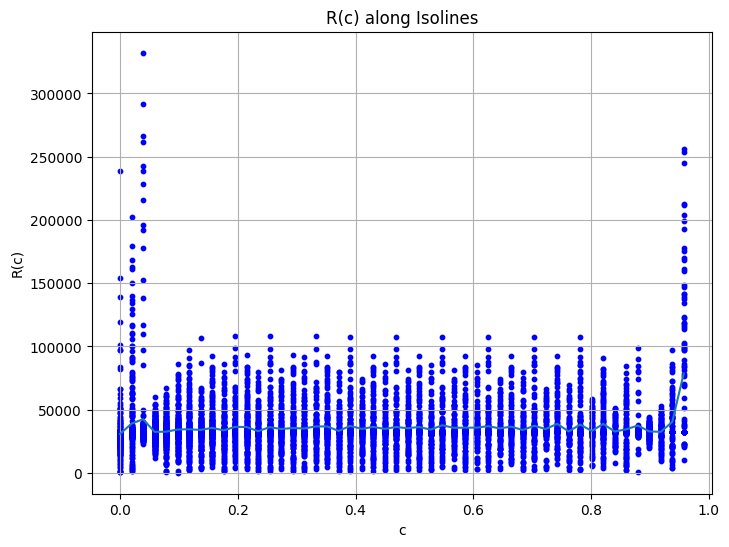

In [167]:
# Collect R along isolines of c
c_values = np.linspace(np.min(c), np.max(c), 50)  # Define isolines at different c values
R_collected = []

for c_val in c_values:
    # Find indices where c is close to the isoline value
    mask = np.isclose(c, c_val, atol=0.01)
    Rs = R_field_fixed_outliers[mask.T]
    
    if len(Rs) > 0:
        R_collected.append(Rs)

# Plot R(c)
plt.figure(figsize=(8, 6))
for i, R_vals in enumerate(R_collected):
    plt.scatter([c_values[i]] * len(R_vals), R_vals, color='b', s=10)
mean_R = np.array([np.mean(x) for x in R_collected])
plt.plot(c_values, mean_R)

plt.title('R(c) along Isolines')
plt.xlabel('c')
plt.ylabel('R(c)')
plt.grid(True)
plt.show()


$$
c(x,0) = 0 \\
\frac{d c}{dx}(x,t) = t x^3 + x t^3 + x^2 + t^2
$$

$$
\frac{d c}{dt}(x,t) = x t + 1 \\
\frac{d^2 c}{dx^2}(x,t) = t x^3 + x t^3 + x^2 + t^2
$$

Solve for $c(x,t)$.

-------

$$
R = d2cdx2 / dcdt = (x^2 + t^2)
dcdt(x,t) = x t + 1
d2cdx2(x,t) = (x^2 + t^2) dcdt(x,t)
            = (x^2 + t^2) (x t + 1)
            = t x^3 + x t^3 + x^2 + t^2
=>
c(x,t) = 1/2 x t^2 + t + q(x)
und
c(x,t) = t/20 x^5 + 1/6 x^3 t^3 + 1/12 x^4 + 1/2 x^2 t^2 + x p(t) + s(t)

=>
0 = t/20 x^5 + 1/12 x^4 + 1/6 x^3 t^3 + 1/2 x^2 t^2 + x (p(t) - 1/2 t^2) + s(t) - t - q(x)
$$